In [1]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots
using ArrheniusModel
using RecursiveArrayTools
using Statistics

In [2]:
function arrhenius_rate(pe::PhaseEnergies, T=300)
    kb = 8.617e-5 #eV/K
    A = 1.0 # Arrhenius prefactor
    pe.K = A * exp.(-pe.Ea_plus_ΔG ./ (kb * T))
    # Adjust the diagonal elements
    for i in 1:size(pe.K, 1)
        pe.K[i, i] =  -1 * sum(pe.K[i, [1:i-1; i+1:end]])
    end
end

arrhenius_rate (generic function with 2 methods)

In [12]:
rng = Xoshiro(0)
G = [-5.92, -5.942, -5.97]
Ea = [0.00 1.00 0.01; 1.00 0.00 1.00; 0.01 1.00 0.00]
pe = PhaseEnergies(G, Ea)
T = 300.0
t= 10
dt = 0.05
datasize = Int(t/0.5+1)
num_steps = floor(Int, t/dt)
num_layers = floor(Int, t/0.5)+1
flow_rate = 0.5
decay_coefficient = 0.00001 * flow_rate
fcoeff = flow_coefficient("exponential", num_layers, decay_coefficient)

function deposition_rates!(dc, c, p, t)
    # Unpack parameters
    fcoeff, pe, j0, j, dt, num_steps, num_layers = p
    # Calculate deposition rates
    j = floor(Int, t / 0.5) + 1
    f = reverse(fcoeff[j: num_layers+j-1])
    dc .= c .* f * pe.K
    if j != j0
        c[j+1, 1] = 1.0
        j = j0
    end
end

n = n_phases(pe)
c0 = zeros(num_layers, n)
c0[1, 1] = 1.0
arrhenius_rate(pe, T)
j = 0
j0 = 0
p = (fcoeff, pe, j0, j, dt, num_steps, num_layers)
tspan = (0.0, (num_steps-1) * dt)
tsteps = range(tspan[1], tspan[2]; length = datasize)
prob = ODEProblem(deposition_rates!, c0, tspan, p)
ode_data = Array(solve(prob, Euler(), saveat = 0.5, dt = dt)) #Training data
ode_data_avg = mean(ode_data, dims=1)
ode_data_avg = reshape(ode_data_avg, (3, 21))
ode_data

21×3×21 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.714042      7.20251e-18   0.285958
 1.0          -9.76963e-49  -4.1859e-32
 3.64848e-30   0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 ⋮                          
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0.0           0.0
 0.0           0

In [13]:
inputs = [T, flow_rate]
input_size = length(inputs)  # Replace with the actual size of `inputs` if it's not a 1D vector
Ea_size = n ^ 2 - n
fcoeff_size = length(fcoeff) #sigmoid 0~1
precoeff_size = 1
output_size = Ea_size + fcoeff_size + precoeff_size
nn = Chain(
    Dense(input_size, 24, tanh),
    Dense(24, 96, tanh),
    Dense(96, output_size, sigmoid)
)
#Combine activation functions and setup constraints
#Normalize the input


Chain(
    layer_1 = Dense(2 => 24, tanh_fast),  # 72 parameters
    layer_2 = Dense(24 => 96, tanh_fast),  # 2_400 parameters
    layer_3 = Dense(96 => 48, sigmoid_fast),  # 4_656 parameters
)         # Total: 7_128 parameters,
          #        plus 0 states.

In [8]:
#For debugging

dp, dst = Lux.setup(rng, nn)
model_debug = Lux.Experimental.@debug_mode nn

try
    model_debug(inputs, dp, dst)
catch e
    println(e)
end

┌ Info: Input Type: Vector{Float64} | Input Structure: (2,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:68
┌ Info: Running Layer: Dense(2 => 24, tanh_fast) at location KeyPath(:nn, :layers, :layer_1)!
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:69
┌ Info: Output Type: Vector{Float64} | Output Structure: (24,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:83
┌ Info: Input Type: Vector{Float64} | Input Structure: (24,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:68
┌ Info: Running Layer: Dense(24 => 96, tanh_fast) at location KeyPath(:nn, :layers, :layer_2)!
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:69
┌ Info: Output Type: Vector{Float64} | Output Structure: (96,)
└ @ Lux.Experimental C:\Users\heyye\.julia\packages\Lux\LhwgF\src\contrib\debug.jl:83
┌ Info: Input Type: Vector{Float64} | Input Stru

([0.5706345482638139, 0.5555644860191663, 0.4520816526114464, 0.6229510834757906, 0.4439940920728929, 0.6694971870768325, 0.5110487738713804, 0.3506718085674412, 0.7016702342186636, 0.5648556785477324  …  0.4316843574555884, 0.4902802879863806, 0.5450454361232042, 0.49324622958425723, 0.5199463480861243, 0.6898630590056051, 0.7419049547554091, 0.4741524171947548, 0.5756113368981867, 0.4482402617448341], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [32]:
p, st = Lux.setup(rng, nn)

((layer_1 = (weight = Float32[0.26014215 -0.31765938; -0.2483299 0.47615117; … ; -0.45217153 0.0100430185; -0.3224169 -0.33375162], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.17928961 0.04442722 … 0.09264644 0.14382608; -0.040314037 -0.13272226 … -0.19887306 -0.013877117; … ; 0.086540565 -0.008985474 … 0.07133462 -0.09290026; 0.019291885 -0.14781038 … -0.18692528 -0.1930875], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.07506567 0.01767646 … -0.17874578 -0.04277921; 0.08653555 -0.018116726 … -0.0016465989 -0.06435944; … ; -0.122471385 0.058717187 … -0.07862515 -0.072850935; 0.15701945 -0.02723378 … 0.097225234 -0.107798696], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [7]:
println(j,j0,c0)

00[1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]


In [33]:
function model_rates!(du, u, p, t)
    # Unpack parameters
    p_pe, p_fcoeff, p_precoeff = p
    # Calculate deposition rates
    j = floor(Int, t / 0.5) + 1
    f = reverse(p_fcoeff[j: num_layers+j-1])
    du .= p_precoeff * u .* f * p_pe.K
    if j != j0
        u[j+1, 1] = 1.0
        j = j0
    end
end

function predict_neuralode(p)
    # Get parameters from the neural network
    inputs = [0.1, flow_rate] #Normalize 300K to 0.1 at this time point
    output, outst = nn(inputs, p, st)

    # Segregate the output
    pp_Ea = output[1:Ea_size]
    p_Ea = zeros(n, n)
    index = 1
    for i in 1:n
        for j in 1:n
            if i != j
                p_Ea[i, j] = pp_Ea[index]
                index += 1
            end
        end
    end
    p_fcoeff = output[Ea_size+1:Ea_size+fcoeff_size]
    p_precoeff = output[end]  # The last element
    p_pe = PhaseEnergies(G, p_Ea)
    # Amorphous phase goes to zero
    nn_output = (p_pe, p_fcoeff, p_precoeff)
    arrhenius_rate(p_pe, T)

    # Define the ODE problem with the parameters from the neural network
    prob = ODEProblem(model_rates!, c0, tspan, nn_output)

    # Solve the ODE
    sol = solve(prob, Euler(), saveat = 0.5, dt = dt)
    return Array(sol)
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

T = 300.0  # Example temperature
flow_rate = 1.0  # Example flow rate
#ps = T, flow_rate, p, st, ode_data
# Predict using the NeuralODE
pred = predict_neuralode(p)
println("Training data: ", size(ode_data))
println("Prediction:", size(pred))
println("Training size: ", size(ode_data[:, :, 1]))
println(pred[:, :, 4])
println("prediction size: ", size(pred[:, :, 1]))
#!!Instability happens at 4th timestep since the weights are randomly initialized (num too large)

# Calculate loss
loss, pred = loss_neuralode(p)

println("Loss: ", loss)
println("Prediction: ", pred)

Training data: (21, 3, 21)
Prediction:(21, 3, 21)
Training size: (21, 3)
[0.9999999991541818 1.020291100203218e-10 7.437886556875257e-10; 0.999999999450195 9.409038666995409e-11 6.859156390738198e-10; 0.9999999996776684 6.047996291900528e-11 4.4089682121233426e-10; 0.9999999999744221 2.7768653481023158e-11 2.0243251567091242e-10; 1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
prediction size: (21, 3)
Loss: 230.09808067058992
Prediction: [1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.9999999997032463 3.5796715413865646e-11 2.609568072864235e-10; 1.0 2.7768653481023207e-11 2.024325156709127

In [19]:
println(size(ode_data[:,1,:]), ode_data[:,1,:])
println(size(ode_data))
#Average the ode_data to get the average concentration of each phase at every timestep
ode_data_avg = mean(ode_data, dims=1)
ode_data_avg = reshape(ode_data_avg, (3, 21))
println(size(ode_data_avg))
display(ode_data_avg[:,:])

3×21 Matrix{Float64}:
 0.047619  0.0952379    0.190476     0.238094     …  0.999959     0.999955
 0.0       1.94406e-17  5.92976e-17  1.26486e-16     7.11474e-15  7.98056e-15
 0.0       2.17157e-7   6.29754e-7   1.28122e-6      4.09317e-5   4.48401e-5

(21, 21)[1.0 0.999995439696844 0.9999908794380116 0.9999863192280625 0.9999817590647158 0.999977198947971 0.9999726388755474 0.9999680788497246 0.9999635188705019 0.9999589589378788 0.9999543990518546 0.9999498392124287 0.9999452794196007 0.9999407196733697 0.9999361599737352 0.9999316003206967 0.9999270407142538 0.9999224811544055 0.9999179216411516 0.9999133621744911 0.9999092586974113; 0.0 1.0 0.9999958957260885 0.999991335467156 0.9999867752548266 0.9999822150890998 0.9999776549676948 0.9999730948928912 0.9999685348646883 0.9999639748830855 0.9999594149480825 0.9999548550596783 0.9999502952178724 0.9999457354226644 0.9999411756740535 0.9999366159720392 0.999932056316621 0.9999274967077981 0.99992293714557 0.9999183776299362 0.999914274108781; 0.0 3.648481686647177e-30 1.0 0.999995439696844 0.9999908794402917 0.9999863192303426 0.9999817590647159 0.999977198945691 0.9999726388732675 0.9999680788474447 0.9999635188682221 0.9999589589355989 0.9999543990495747 0.9999498392101489 0.9999

In [10]:
propertynames(nn)

(:layers, :name)

In [11]:
propertynames(nn.layers[1])

(:activation, :in_dims, :out_dims, :init_weight, :init_bias)

In [34]:
# Callback function to observe training
loss_values = Float64[]
callback = function (p, l, pred; doplot = false)
    println(l)
    push!(loss_values, l)
    # plot current prediction against data
    if doplot
        pred_avg = mean(pred, dims=1)
        pred_avg = reshape(pred_avg, (3, 21))
        #plot the three phases from ode_data_avg and pred_avg
        plt = scatter(tsteps, ode_data_avg[1, :], label = "Phase 1 Data", color = :blue)
        scatter!(plt, tsteps, ode_data_avg[2, :], label = "Phase 2 Data", color = :red)
        scatter!(plt, tsteps, ode_data_avg[3, :], label = "Phase 3 Data", color = :green)
        scatter!(plt, tsteps, pred_avg[1, :], label = "Phase 1 Prediction", color = :blue, shape = :cross)
        scatter!(plt, tsteps, pred_avg[2, :], label = "Phase 2 Prediction", color = :red, shape = :cross)
        scatter!(plt, tsteps, pred_avg[3, :], label = "Phase 3 Prediction", color = :green, shape = :cross)
        display(plot(plt))
        savefig(plt, "training.png")
    end
    return false
end

pinit = ComponentArray(p)

callback(pinit, loss_neuralode(pinit)...)

230.09808067058992


false

In [13]:
println(typeof(pinit))

ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:102, Axis(weight = ViewAxis(1:68, ShapedAxis((34, 2))), bias = ViewAxis(69:102, ShapedAxis((34, 1))))), layer_2 = ViewAxis(103:3672, Axis(weight = ViewAxis(1:3468, ShapedAxis((102, 34))), bias = ViewAxis(3469:3570, ShapedAxis((102, 1))))), layer_3 = ViewAxis(3673:8925, Axis(weight = ViewAxis(1:5202, ShapedAxis((51, 102))), bias = ViewAxis(5203:5253, ShapedAxis((51, 1))))))}}}


In [35]:
# Train using the Adam optimizer
adtype = Optimization.AutoFiniteDiff()

optf = Optimization.OptimizationFunction((p,_) -> loss_neuralode(p), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.02); callback = callback, maxiters = 300)


230.09808067058992
228.432682940625
84.01448680269162
5.293978639110292
14.8286143656392
12.67839726655173
10.279812348535433
6.212636790482437
5.3865307285491015
4.672186929446491
3.8285312666054514
4.068687321996074
4.920819674338306
4.365591138110439
3.636734259654548
3.4819452038949517
3.5228398729415877
3.483164087844848
3.352415754120035
3.154382958646597
2.887734324483671
2.58345189236815
2.3596402758231814
2.3989912161246143
2.597766180134069
2.455805510453336
2.1559963185112965
2.0663304009701267
2.0982418193468817
2.0927541291411664
1.9904479508311264
1.8274036255590609
1.737479399160776
1.7748591619276715
1.6997965969857955
1.5722515956507785
1.5543204152142724
1.551714748113394
1.482417954228564
1.3781947332529492
1.344004800207745
1.3850143454945096
1.3521873086153247
1.3081315491069119
1.328797656287089
1.3540768071720106
1.3382988180778463
1.3030958329204576
1.2989021726657877
1.313251690261738
1.286458250195542
1.258198268811583
1.2623348375650192
1.2550521848211358
1.2

retcode: Default
u: ComponentVector{Float32}(layer_1 = (weight = Float32[0.2477524 -0.32968226; -0.22616374 0.4977203; … ; -0.5779818 -0.12104844; -0.4207902 -0.42996842], bias = Float32[-0.0120229535; 0.021568833; … ; -0.13109142; -0.09621714;;]), layer_2 = (weight = Float32[-0.060261484 -0.07767995 … 0.18528427 0.2610891; -0.19884937 0.024812639 … -0.35490555 -0.17053534; … ; -0.03415017 0.113903314 … -0.033074334 -0.21388976; 0.1721055 -0.3002158 … -0.040839966 -0.041893754], bias = Float32[-0.12639177; 0.15617849; … ; 0.12586357; -0.15171592;;]), layer_3 = (weight = Float32[0.079082504 0.013456697 … -0.18310353 -0.03822055; 0.080471314 -0.009428397 … 0.013415019 -0.079159126; … ; -0.122471385 0.058717187 … -0.07862515 -0.072850935; 0.24893288 -0.094656974 … 0.086557135 -0.1442475], bias = Float32[-0.0068024825; 0.04261871; … ; 0.0; 0.09007893;;]))

In [36]:
using Dates
plt = scatter!(loss_values, title="Loss Transformation", xlabel="Iteration", ylabel="Loss")

# Generate a unique filename using the current timestamp
timestamp = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
filename = "loss_transformation_$timestamp.png"

# Save the plot to a file
savefig(plt, filename)

"g:\\My Drive\\Ga2O3\\DiffEqFlux\\loss_transformation_2024-07-30_14-07-13.png"

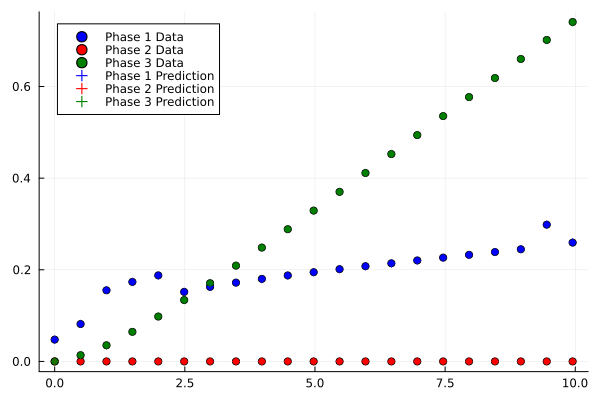

0.0776655179468766


false

In [37]:
callback(result_neuralode.u, loss_neuralode(result_neuralode.u)...; doplot = true)
#scatter!(plt, tsteps, loss_neuralode(result_neuralode.u)[2][1, :]; label = "prediction") # hide

In [38]:
display(predict_neuralode(result_neuralode.u)[:, :, 21])
display(ode_data[:, :, 21])

21×3 Matrix{Float64}:
 0.131117  7.81202e-17  0.868883
 0.13111   7.81211e-17  0.86889
 0.126971  7.86161e-17  0.873029
 0.126974  7.86158e-17  0.873026
 0.126976  7.86156e-17  0.873024
 0.131115  7.81204e-17  0.868885
 0.131115  7.81204e-17  0.868885
 0.131115  7.81204e-17  0.868885
 0.133493  7.78378e-17  0.866507
 0.133493  7.78378e-17  0.866507
 ⋮                      
 0.162057  7.45658e-17  0.837943
 0.166103  7.41181e-17  0.833897
 0.22177   6.82417e-17  0.77823
 0.285916  6.18993e-17  0.714084
 0.295249  6.10038e-17  0.704751
 0.407082  5.06227e-17  0.592918
 0.561252  3.69796e-17  0.438748
 0.749212  2.09101e-17  0.250788
 1.0       2.85898e-24  3.45975e-8

21×3 Matrix{Float64}:
 0.126618  7.83502e-17  0.873382
 0.126797  7.46682e-17  0.873203
 0.127014  7.16547e-17  0.872986
 0.127367  6.83049e-17  0.872633
 0.12789   6.49527e-17  0.87211
 0.128764  6.12613e-17  0.871236
 0.129967  5.78999e-17  0.870033
 0.131756  5.45307e-17  0.868244
 0.134415  5.11496e-17  0.865585
 0.138367  4.77511e-17  0.861633
 ⋮                      
 0.165958  3.73433e-17  0.834042
 0.185257  3.37378e-17  0.814743
 0.213945  3.00056e-17  0.786055
 0.25659   2.60851e-17  0.74341
 0.319983  2.18847e-17  0.680017
 0.414218  1.72683e-17  0.585782
 0.554302  1.20334e-17  0.445698
 0.737811  6.54736e-18  0.262189
 1.0       0.0          0.0

In [43]:
inputs = [0.1, flow_rate]
trained_model = result_neuralode.u
output, outst = nn(inputs, trained_model, st)
pp_Ea = output[1:Ea_size]
p_Ea = zeros(n, n)
index = 1
for i in 1:n
    for j in 1:n
        if i != j
            p_Ea[i, j] = pp_Ea[index]
            index += 1
        end
    end
end
# Segregate the output
display(p_Ea)
display(pe.Ea)
p_fcoeff = output[Ea_size+1:Ea_size+fcoeff_size]
p_precoeff = output[end]
display(p_fcoeff)
display(fcoeff)
display(p_precoeff)


3×3 Matrix{Float64}:
 0.0         0.614089  0.931841
 0.957317    0.0       0.998994
 1.59115e-7  0.997242  0.0

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
 0.0   1.0  0.01
 1.0   0.0  1.0
 0.01  1.0  0.0

41-element Vector{Float64}:
 0.2624624872522452
 0.6628285580762386
 0.6803659205204323
 0.5112212498987658
 0.7577081432448799
 0.852015855493124
 0.6728261287725281
 0.6770348889372603
 0.422234821715259
 0.18432566558874394
 ⋮
 4.678041470528786e-8
 4.42002781052632e-9
 1.061892046033376e-6
 3.334376421109649e-10
 1.560522186150479e-8
 5.510133643473923e-11
 7.283231915342705e-11
 1.6771266627684577e-11
 0.781983179353148

41-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.9999350021124542
 0.9999300024499428
 0.9999250028124297
 0.9999200031999147
 0.9999150036123976
 0.9999100040498785
 0.9999050045123571
 0.9999000049998333
 0.999895005512307

0.6323944466322362